In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
from itertools import cycle, islice
from lib import models
from lib.nyt_connections import get_connections_games
from lib.pack import packed_tensors_from_tokenized_results, plot_packed_tensors
from lib.recipe import ComponentConfig, TuneRecipeConfig
from lib.tasks import ChatCompletionParams, get_task_results, Task
from lib.tokenize import TaskResultTokenizer
from lib.tune import tune
from lib.vllm import start_vllm
import openai
from openai.types.chat.chat_completion import Choice
import os
import torch
from transformers import AutoTokenizer
from typing import Iterable


games = get_connections_games()
games

[ConnectionsGame(board={'WET WEATHER': ConnectionsGroup(level=0, members=['HAIL', 'RAIN', 'SLEET', 'SNOW']), 'NBA TEAMS': ConnectionsGroup(level=1, members=['BUCKS', 'HEAT', 'JAZZ', 'NETS']), 'KEYBOARD KEYS': ConnectionsGroup(level=2, members=['OPTION', 'RETURN', 'SHIFT', 'TAB']), 'PALINDROMES': ConnectionsGroup(level=3, members=['KAYAK', 'LEVEL', 'MOM', 'RACECAR'])}, starting_board=[['SNOW', 'LEVEL', 'SHIFT', 'KAYAK'], ['HEAT', 'TAB', 'BUCKS', 'RETURN'], ['JAZZ', 'HAIL', 'OPTION', 'RAIN'], ['SLEET', 'RACECAR', 'MOM', 'NETS']], created_at=datetime.datetime(2023, 6, 12, 0, 0, tzinfo=zoneinfo.ZoneInfo(key='UTC')), id=1, name='Connections #1'),
 ConnectionsGame(board={'FOOTWEAR': ConnectionsGroup(level=0, members=['BOOT', 'LOAFER', 'PUMP', 'SNEAKER']), 'UNITS OF LENGTH': ConnectionsGroup(level=1, members=['FOOT', 'LEAGUE', 'MILE', 'YARD']), 'MAGAZINES': ConnectionsGroup(level=2, members=['ESSENCE', 'PEOPLE', 'TIME', 'US']), 'LETTER HOMOPHONES': ConnectionsGroup(level=3, members=['ARE', 'Q

In [7]:
prompts = [
    "Find groups of four items that share something in common. Output them in the following format: four total lines. On each line, there should be four comma-separated items. No additional text (like group titles or descriptions) should be in the output. Also, there should not be anything in your output before or after the solution.",
    "Group words that share a common thread. There are four words for each common thread. Output them in the following format: four total lines. On each line, there should be four comma-separated items. No additional text (like group titles or descriptions) should be in the output. Also, there should not be anything in your output before or after the solution.",
    "This is a puzzle. Create four groups of four. Words in each group fit under a specific category. Some categories might be defined by their use of wordplay (palindromes, homophones, adding or dropping letters and words) rather than the literal meanings of the words on the cards. Output them in the following format: four total lines. On each line, there should be four comma-separated items. No additional text (like group titles or descriptions) should be in the output. Also, there should not be anything in your output before or after the solution.",
]


def get_tasks() -> Iterable[Task]:
    for game, (prompt, lowercase) in zip(
        cycle(games),
        cycle((prompt, lowercase) for prompt in prompts for lowercase in [True, False]),
    ):

        def grader(choice: Choice, game=game) -> float:
            assistant_content = choice.message.content
            assert assistant_content is not None
            assistant_content = assistant_content.strip()
            groups = [
                frozenset(word.strip().upper() for word in line.split(","))
                for line in assistant_content.split("\n")[-len(game.board) :]
            ]
            reward = 0
            for _, group_contents in game.board.items():
                if set(group_contents.members) in groups:
                    reward += 1 / len(game.board)
            return reward

        yield Task(
            messages=[
                {
                    "role": "user",
                    "content": f"{prompt}\nWords:\n\n{"\n".join(word.lower() if lowercase else word for row in game.starting_board for word in row)}",
                }
            ],
            grader=grader,
        )


tasks = list(islice(get_tasks(), len(games) * 2))
# distill_tasks = tasks[:436]
distill_tasks = tasks[:160]
val_tasks = tasks[436:508]
test_tasks = tasks[508 : len(games)]
train_tasks = tasks[len(games) : len(games) + 436]
len(distill_tasks), len(val_tasks), len(test_tasks), len(train_tasks)

(160, 72, 92, 436)

In [8]:
model = models.qwen_7b
base_model = model.base_model
tokenizer = AutoTokenizer.from_pretrained(base_model)

distill_client = openai.AsyncOpenAI(
    base_url="https://api.fireworks.ai/inference/v1",
    api_key=os.getenv("FIREWORKS_API_KEY"),
)
distill_model = "accounts/fireworks/models/deepseek-r1"

tokenized_results = [
    result
    for results in await get_task_results(
        tasks=distill_tasks,
        client=distill_client,
        model=distill_model,
        params=ChatCompletionParams(
            max_tokens=2**17,
            logprobs=True,
            top_logprobs=5,
        ),
        transform=TaskResultTokenizer(tokenizer),
    )
    for result in results
]
print(
    "Max sequence length:",
    max(len(tokenized_result.token_ids) for tokenized_result in tokenized_results),
)
print(
    "Number of results with no logprobs:",
    sum(
        1
        for tokenized_result in tokenized_results
        if tokenized_result.token_logprobs is None
    ),
)

  0%|          | 0/160 [00:00<?, ?it/s]

Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs
Assistant tokens are not equal, skipping token logprobs
Max sequence length: 11534
Number of results with no logprobs: 7


Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping


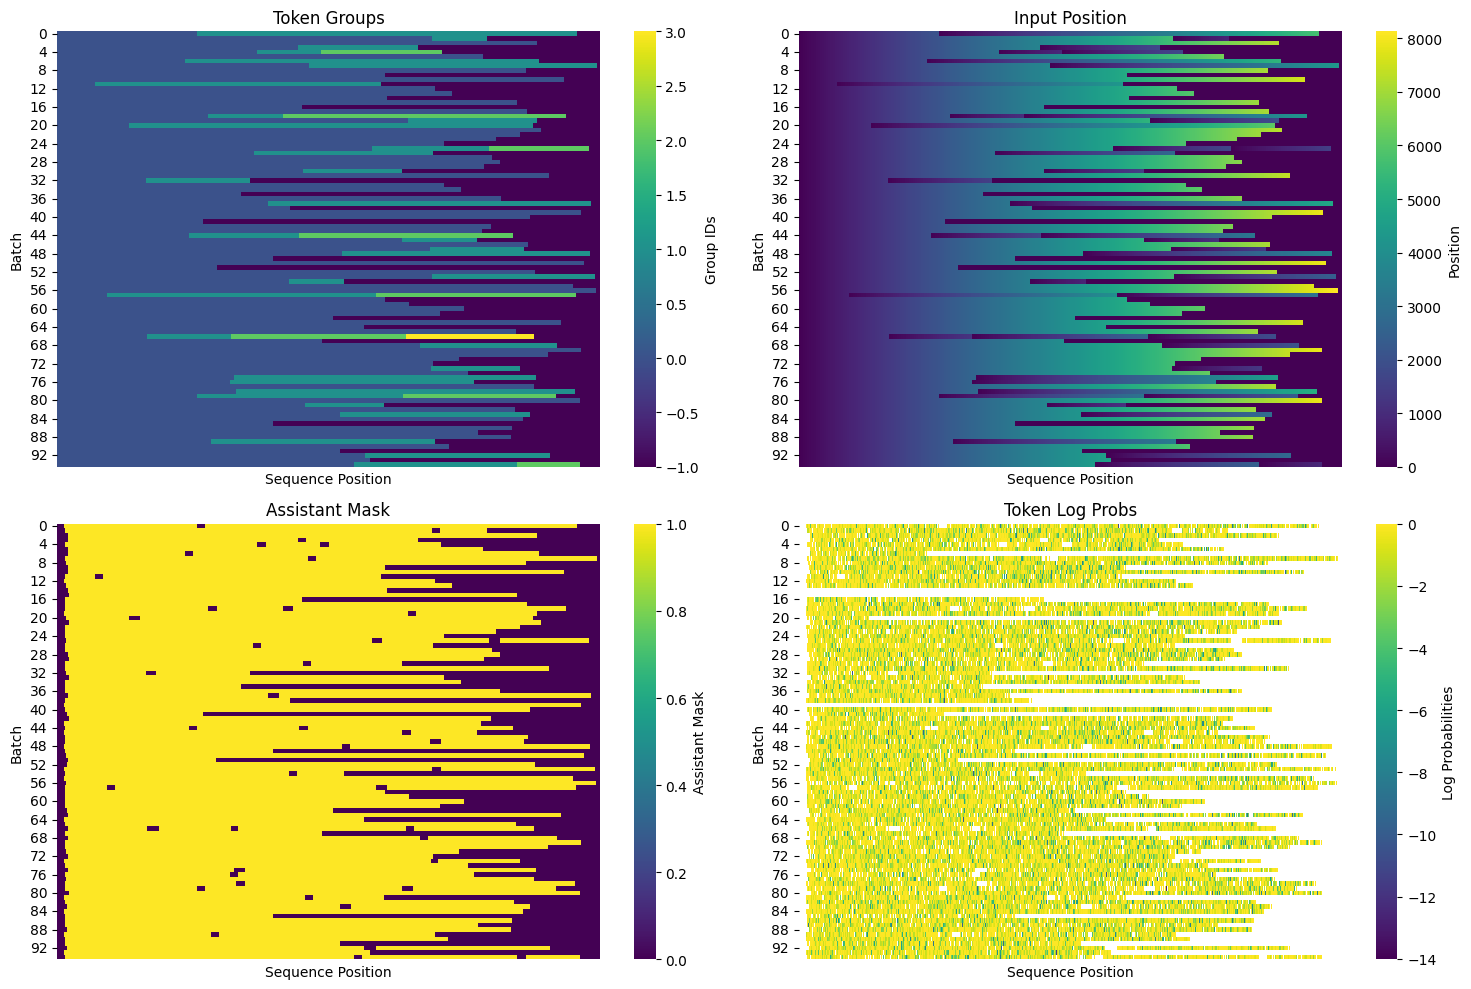

{'tokens': tensor([[151646, 151644,   9885,  ..., 151643, 151643, 151643],
         [151646, 151644,   2808,  ..., 151643, 151643, 151643],
         [151646, 151644,   1986,  ..., 151643, 151643, 151643],
         ...,
         [151646, 151644,   1986,  ..., 151643, 151643, 151643],
         [151646, 151644,   9885,  ..., 151643, 151643, 151643],
         [151646, 151644,   9885,  ..., 151643, 151643, 151643]]),
 'group_ids': tensor([[ 0,  0,  0,  ..., -1, -1, -1],
         [ 0,  0,  0,  ..., -1, -1, -1],
         [ 0,  0,  0,  ..., -1, -1, -1],
         ...,
         [ 0,  0,  0,  ..., -1, -1, -1],
         [ 0,  0,  0,  ..., -1, -1, -1],
         [ 0,  0,  0,  ..., -1, -1, -1]]),
 'input_pos': tensor([[0, 1, 2,  ..., 0, 0, 0],
         [0, 1, 2,  ..., 0, 0, 0],
         [0, 1, 2,  ..., 0, 0, 0],
         ...,
         [0, 1, 2,  ..., 0, 0, 0],
         [0, 1, 2,  ..., 0, 0, 0],
         [0, 1, 2,  ..., 0, 0, 0]]),
 'assistant_mask': tensor([[False, False, False,  ..., False, False, F

In [9]:
seq_len = 8192
packed_tensors = packed_tensors_from_tokenized_results(
    tokenized_results,
    seq_len=seq_len,
    pad_token_id=tokenizer.pad_token_id,  # type: ignore
)
plot_packed_tensors(packed_tensors)
packed_tensors

In [14]:
seq_len * 6

49152

In [17]:
(49152) // seq_len


6

In [18]:
model.tune_max_batch_tokens

16384

In [43]:
seq_len * 4

32768

In [ ]:
from lib.models import Model
from torchtune.models.qwen2_5 import qwen2_5_7b_base, qwen2_5_14b_base

model = Model(
    base_model="deepseek-ai/DeepSeek-R1-Distill-Qwen-7B",
    tune_model=qwen2_5_7b_base,
    tune_model_type="QWEN2",
    tune_max_batch_tokens=49152,
    tune_optimizer=ComponentConfig(
        "torch.optim.AdamW",
        lr=2e-5,
        fused=True,
    ),
    vllm_named_arguments={},
)
model = Model(
    base_model="deepseek-ai/DeepSeek-R1-Distill-Qwen-14B",
    tune_model=qwen2_5_14b_base,
    tune_model_type="QWEN2",
    tune_max_batch_tokens=24576,
    tune_optimizer=ComponentConfig(
        "torchao.prototype.low_bit_optim.AdamW8bit",
        lr=2e-5,
    ),
    vllm_named_arguments={},
)

distilled_model = await tune(
    base_model=model.base_model,
    output_dir="./models/rl1",
    packed_tensors=packed_tensors,
    model=model.tune_model,
    model_type=model.tune_model_type,
    config=TuneRecipeConfig(
        optimizer=model.tune_optimizer,
        batch_size=model.tune_max_batch_tokens // seq_len,
        enable_activation_checkpointing=True,
        enable_activation_offloading=True,
        custom_sharded_layers=["tok_embeddings", "output"],
        num_output_chunks=4,
    ),
)

$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/rl1/config.yaml
Running with torchrun...


W0216 00:56:36.763000 45113 torch/distributed/run.py:793] 
W0216 00:56:36.763000 45113 torch/distributed/run.py:793] *****************************************
W0216 00:56:36.763000 45113 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0216 00:56:36.763000 45113 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 3
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-14B/snapshots/5ee96d8a09692e87087a6e0496d87124a1cdc3fe
  checkpoint_files:
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-14B/snapshots/5ee9

Writing logs to models/rl1/logs/log_1739667401.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 16.12 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 34.14 GiB
	GPU peak memory reserved: 35.05 GiB
	GPU peak memory active: 34.14 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|10|Loss: 1.1094:  62%|██████▎   | 10/16 [03:53<02:04, 20.69s/it, loss=1.11, lr=tensor(2.0000e-05)]

In [7]:
distilled_model = "./models/rl1/0001"

In [58]:
vllm = await start_vllm(
    base_model,
    # env={"VLLM_ALLOW_LONG_MAX_MODEL_LEN": "1"},
    max_concurrent_requests=128,
    named_arguments=dict(
        block_size=32,
        disable_log_requests=True,
        # enable_chunked_prefill=True,
        enable_prefix_caching=True,
        enforce_eager=True,
        gpu_memory_utilization=0.9,
        max_model_len=16384,
        max_num_seqs=128,
        # max_num_batched_tokens=16384,
        num_scheduler_steps=4,
        preemption_mode="swap",
        return_tokens_as_token_ids=True,
        swap_space=80,
    ),
    timeout=120 + 15 * torch.cuda.device_count(),
)
vllm

$ vllm serve deepseek-ai/DeepSeek-R1-Distill-Qwen-7B --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.9 --max-model-len=16384 --max-num-seqs=128 --num-scheduler-steps=4 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --port=8006 --api-key=default
INFO 02-15 02:14:02 __init__.py:190] Automatically detected platform cuda.
INFO 02-15 02:14:03 api_server.py:840] vLLM API server version 0.7.2
INFO 02-15 02:14:03 api_server.py:841] args: Namespace(subparser='serve', model_tag='deepseek-ai/DeepSeek-R1-Distill-Qwen-7B', config='', host=None, port=8006, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', response_role='assistant', ssl_keyfile=None, ssl_certfile=None, ssl_ca_certs=None, ssl_cert_reqs=0, root_path=None, middleware=[], retu

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:01<00:01,  1.35s/it]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:03<00:00,  1.61s/it]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:03<00:00,  1.57s/it]



INFO 02-15 02:14:34 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-15 02:14:35 worker.py:267] Memory profiling takes 1.21 seconds
INFO 02-15 02:14:35 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.90) = 71.19GiB
INFO 02-15 02:14:35 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 2.20GiB; the rest of the memory reserved for KV Cache is 54.57GiB.
INFO 02-15 02:14:35 executor_base.py:110] # CUDA blocks: 31931, # CPU blocks: 46811
INFO 02-15 02:14:35 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 62.37x
INFO 02-15 02:15:18 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 44.85 seconds
INFO 02-15 02:15:20 api_server.py:756] Using supplied chat template:
INFO 02-15 02:15:20 api_server.py:756] None
INFO 02-15 02:15:20 launcher.py:21] Available routes are:
INFO 02-15 02:15:20 launcher.py:29] Route: /

INFO:     Started server process [106019]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8006 (Press CTRL+C to quit)


INFO 02-15 02:15:22 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:44124 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


vLLM(client=<openai.AsyncOpenAI object at 0x7c54385faa80>, max_concurrent_tokens=1021870, process=<Process 106019>)

In [91]:
tokenized_results = [
    result
    for results in await get_task_results(
        tasks=train_tasks[: 256 // 16],
        client=vllm.client,
        model=base_model,
        cache=False,
        log_results=8,
        n=16,
        params=ChatCompletionParams(
            n=1,
            stream_options={
                "include_usage": True,
            },
        ),
        transform=TaskResultTokenizer(tokenizer),
    )
    for result in results
]

  0%|          | 0/256 [00:00<?, ?it/s]

Final mask shape: torch.Size([63, 8192, 8192])


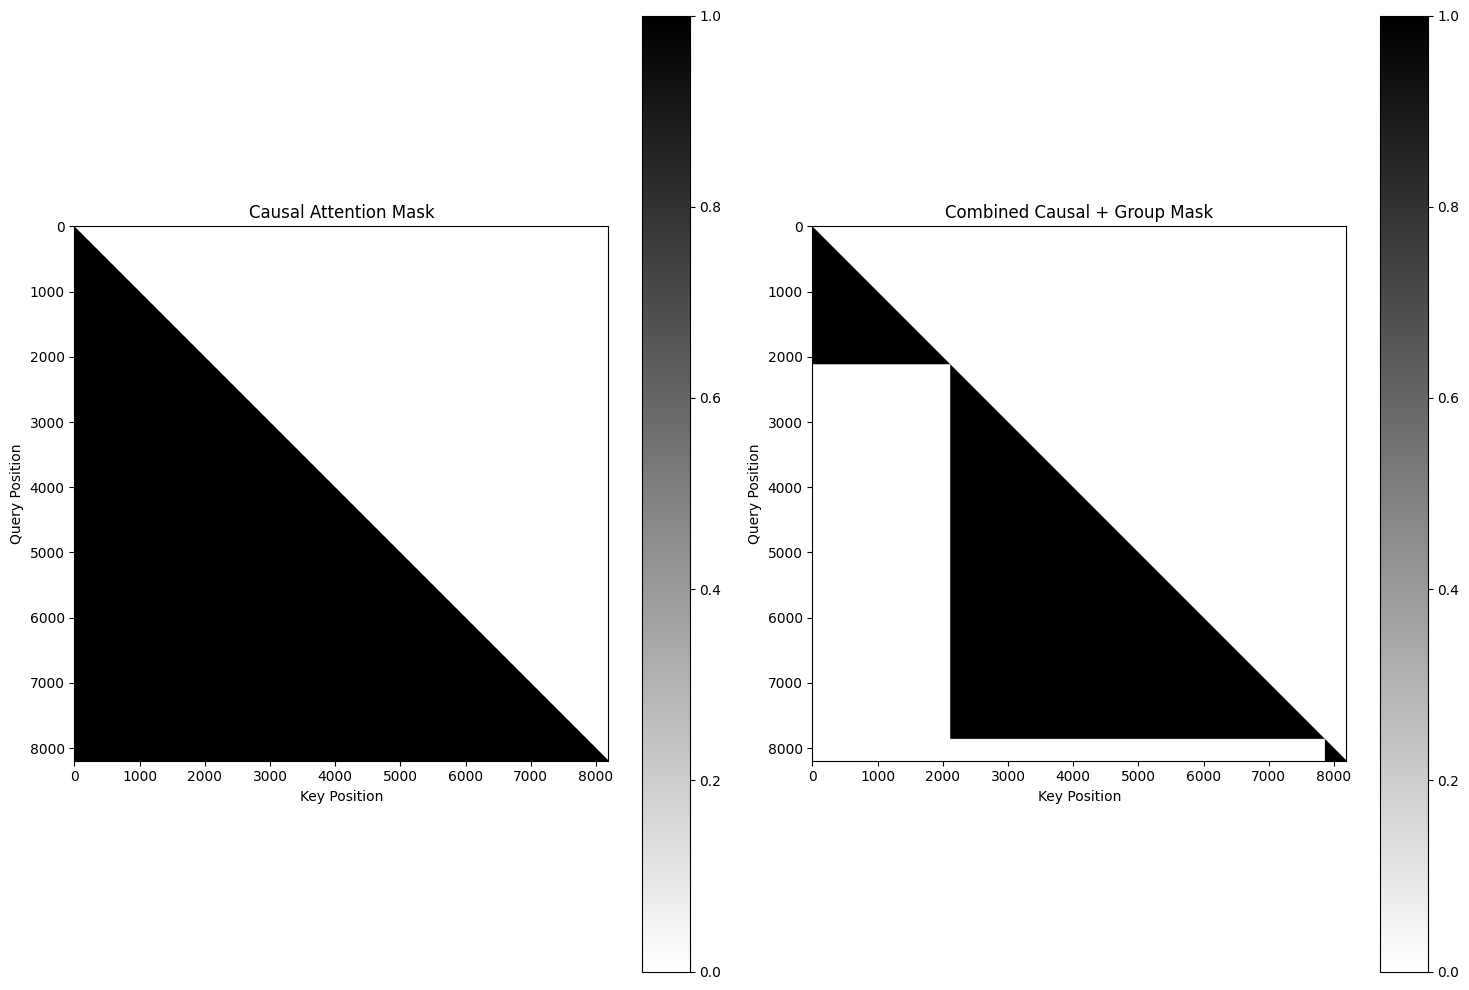

Mask shape: torch.Size([63, 8192, 8192])
Number of allowed attention connections (True values): 1263707944
Percentage of allowed connections: 29.9%


In [10]:
import torch

shape = packed_tensors["tokens"].shape

# Create causal attention mask for the batch size and sequence length
batch_size = shape[0]
seq_length = shape[1]

causal_mask = (
    torch.tril(torch.ones(seq_length, seq_length, dtype=torch.bool))
    .unsqueeze(0)
    .expand(batch_size, seq_length, seq_length)
)
group_mask = packed_tensors["group_ids"].unsqueeze(2) == packed_tensors[
    "group_ids"
].unsqueeze(1)
final_mask = causal_mask & group_mask

# Verify mask shape matches batch size and sequence length
print(f"Final mask shape: {final_mask.shape}")

# Visualize the combined attention mask
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

# Plot causal mask
mask_example = causal_mask[0].cpu().numpy()
im1 = ax1.imshow(mask_example, cmap="binary")
ax1.set_title("Causal Attention Mask")
ax1.set_xlabel("Key Position")
ax1.set_ylabel("Query Position")
plt.colorbar(im1, ax=ax1)

# Plot combined mask
final_mask_example = final_mask[0].cpu().numpy()
im2 = ax2.imshow(final_mask_example, cmap="binary")
ax2.set_title("Combined Causal + Group Mask")
ax2.set_xlabel("Key Position")
ax2.set_ylabel("Query Position")
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Mask shape: {final_mask.shape}")
print(
    f"Number of allowed attention connections (True values): {final_mask.sum().item()}"
)
print(
    f"Percentage of allowed connections: {final_mask.sum().item() / (final_mask.numel()) * 100:.1f}%"
)